In [2]:
import pickle
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import pandas as pd
import jieba
from keras.utils import to_categorical 

def convert_to_chinese(number):
    chinese_numerals = {
        "0": "零",
        "1": "一",
        "2": "二",
        "3": "三",
        "4": "四",
        "5": "五",
        "6": "六",
        "7": "七",
        "8": "八",
        "9": "九",
    }
    chinese_number = "".join([chinese_numerals[str(digit)] for digit in str(number)])
    return chinese_number

# 定義將文本中的阿拉伯數字轉換為中文數字的函數
def convert_numbers_to_chinese(text):
    # 確保text是字符串，如果不是，轉換為字符串
    text = str(text)
    words = jieba.lcut(text)
    converted_words = ''.join([convert_to_chinese(word) if word.isdigit() else word for word in words])
    return converted_words



# 載入第一個程式產生的檔案
with open("tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

word2vec_model = Word2Vec.load("word2vec.model")
embedding_dim = word2vec_model.vector_size  # 取得Word2Vec模型的維度
vocab_list = [word for word,i in word2vec_model.wv.key_to_index.items()]  # 取得
word_index = {" ":0}
word_vector = {}


# 將文本轉換成詞向量
embedding_matrix = np.zeros((len(vocab_list) + 1, embedding_dim))
for i in range(len(vocab_list)):
    word = vocab_list[i]
    word_index[word] = i + 1
    word_vector[word] = word2vec_model.wv[word]
    embedding_matrix[i + 1] = word2vec_model.wv[word]

In [3]:
data = pd.read_excel('train_data.xlsx')

# 將 "輸入" 欄位中的阿拉伯數字轉換為中文數字
data["輸入"] = data["輸入"].apply(convert_numbers_to_chinese)
# 資料預處理（假設已有資料X和標籤y）
X = []
y = []
for i in range(len(data)):
    X.append(jieba.lcut(data["輸入"].iloc[i]))
    y.append(data["分類"].iloc[i])
y_cate = to_categorical(np.asarray(y))


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.228 seconds.
Prefix dict has been built succesfully.


In [4]:
def tokenizer(text, word_index):
    data = []
    for sentence in text:
        new_text = []
        for word in sentence:
            if word in word_index:
                try:
                    new_text.append(word_index[word])
                except:
                    new_text.append(0)
        data.append(new_text)
    data_lengths = [len(sentence) for sentence in data]
    max_length = max(data_lengths)
    
    texts = pad_sequences(data, maxlen=7)
    return texts
with open('word_index.pkl', 'wb') as f:
    pickle.dump(word_index, f)
X = tokenizer(X, word_index)

In [5]:
# 切割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y_cate, test_size=0.2, random_state=42)
# word_index
# X_train = X
# y_train = y

訓練(lstm)

In [ ]:
from keras.models import Sequential, save_model
from keras.layers import Embedding, Bidirectional, LSTM, BatchNormalization, Dense, Dropout
from keras.optimizers import Adam
from keras.constraints import max_norm
from keras.initializers import he_normal
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from datetime import datetime
# 創建模型
model = Sequential()
model.add(Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                    weights=[embedding_matrix], input_length=X.shape[1], 
                    trainable=False, embeddings_initializer=he_normal()))
model.add(Bidirectional(LSTM(64, return_sequences=True, 
                             kernel_constraint=max_norm(5), kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(32, kernel_constraint=max_norm(5), kernel_regularizer=l2(0.01))))
model.add(Dropout(0.3))  # 添加 Dropout 層，可根據需要調整 dropout 比例
model.add(Dense(6, activation='softmax', kernel_regularizer=l2(0.01)))  # 在全連接層上應用 L2 正規化

# 編譯模型，使用學習率調整器
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# 訓練模型，加入 callbacks
# model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Generate today's date in the format YYYYMMDD
today_date = datetime.today().strftime('%Y%m%d')

# Construct the filename using the specified naming convention
filename = f'LSTMmodel_{today_date}.keras'

# Save the entire model in the .keras format with the constructed filename
# save_model(model, filename)
filename

訓練(bigru early stop)

In [ ]:
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, save_model
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout, BatchNormalization
import numpy as np
from keras.regularizers import l2
from datetime import datetime

# Create the Sequential model
model = Sequential()
model.add(Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                    weights=[embedding_matrix], input_length=X.shape[1], 
                    trainable=False))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))

# Compile the model with categorical crossentropy loss and Adam optimizer with specified learning rate
# Also, include accuracy as a metric
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

# Add EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model using the training data and validate on the test data
# Include the ReduceLROnPlateau and EarlyStopping callbacks
# model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stop])

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(X, y_cate, epochs=80, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[reduce_lr,early_stop])

# Generate today's date in the format YYYYMMDD
today_date = datetime.today().strftime('%Y%m%d')

# Construct the filename using the specified naming convention
filename = f'BiLSTMmodel_{today_date}.keras'

# Save the entire model in the .keras format with the constructed filename
save_model(model, filename)


訓練(NN)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, LSTM

from keras.layers import Dropout
Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                                weights=[embedding_matrix], input_length=X.shape[1], 
                                trainable=False)
model = Sequential()
model.add(Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                                weights=[embedding_matrix], input_length=X.shape[1], 
                                trainable=False))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))  # 新增一層 LSTM
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# 打印模型摘要
model.summary()
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, MultiHeadAttention, Embedding, Flatten, LSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.layers import concatenate

# 修改 create_model_with_self_attention 函數
def create_model_with_attention_and_lstm(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']):
    inputs = Input(shape=(X.shape[1],))
    
    # 添加嵌入層，使用預訓練的嵌入矩陣
    embedding_layer = Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                                weights=[embedding_matrix], input_length=X.shape[1], 
                                trainable=False)(inputs)
    
    # 添加自注意力機制（self-attention）
    attention = MultiHeadAttention(num_heads=1, key_dim=50)(embedding_layer, embedding_layer, embedding_layer)
    
    # Flatten 注意力的輸出
    attention_flatten = Flatten()(attention)
    
    # LSTM 層
    lstm_layer = LSTM(64)(embedding_layer)
    
    # 將自注意力的輸出和LSTM的輸出連接
    merged_layer = concatenate([attention_flatten, lstm_layer])
    
    # 全連接層
    dense_layer = Dense(64, activation='relu')(merged_layer)
    batch_norm = BatchNormalization()(dense_layer)
    dropout = Dropout(0.3)(batch_norm)
    
    # 輸出層，使用 softmax 激活函數
    output_layer = Dense(6, activation='softmax')(dropout)
    
    # 創建模型
    model = Model(inputs=inputs, outputs=output_layer)
    
    # 編譯模型
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

# 使用最佳學習率創建具有自注意力機制的模型
model_with_self_attention = create_model_with_attention_and_lstm()

# 生成當天日期的字符串
today_date = datetime.today().strftime('%Y%m%d')

# 構建文件名，使用指定的命名慣例
filename = f'NNmodel_{today_date}.tf'

# 建立 ModelCheckpoint 回調以保存最佳模型
checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
model_with_self_attention.summary()
# 模型訓練
model_with_self_attention.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])


In [ ]:
# print('X.shape:',X.shape)
print('y.shape:',y.shape)
y_train[1]

In [ ]:
# 假設X是你的文本數據，已經通過tokenizer轉換為數字序列

# 計算每個句子的長度
sentence_lengths = [len(sentence) for sentence in X]

# 計算平均數
average_length = sum(sentence_lengths) / len(sentence_lengths)

# 計算中位數
sorted_lengths = sorted(sentence_lengths)
mid = len(sorted_lengths) // 2
median_length = (sorted_lengths[mid] + sorted_lengths[~mid]) / 2  # 使用~mid取得中位數，即使數量為奇數也可正確計算

# 打印結果
print(f"平均數: {average_length}")
print(f"中位數: {median_length}")


訓練(textcnn)

In [28]:
import pandas as pd
import numpy as np
import jieba
import keras
from keras.layers import concatenate, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input
from keras.models import Model, save_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.initializers import he_normal
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# 生成當天日期的字符串
today_date = datetime.today().strftime('%Y%m%d')
#数据预处理
def data_process(path, max_len=50):           #path为句子的存储路径，max_len为句子的固定长度
    dataset = pd.read_csv(path, sep='\t', names=[ 'text', 'label']).astype(str)
    cw = lambda x: list(jieba.cut(x))         # 定义分词函数
    dataset['words'] = dataset['text'].apply(cw)  # 将句子进行分词
    tokenizer = Tokenizer()                   # 创建一个Tokenizer对象，将一个词转换为正整数
    tokenizer.fit_on_texts(dataset['words'])  #将词编号，词频越大，编号越小
    vocab = tokenizer.word_index              # 得到每个词的编号
    x_train, x_test, y_train, y_test = train_test_split(dataset['words'], dataset['label'], test_size=0.1)  #划分数据集
    x_train_word_ids = tokenizer.texts_to_sequences(x_train)     #将测试集列表中每个词转换为数字
    x_test_word_ids = tokenizer.texts_to_sequences(x_test)       #将训练集列表中每个词转换为数字
    x_train_padded_seqs = pad_sequences(x_train_word_ids, maxlen=max_len)  # 将每个句子设置为等长，每句默认为50
    x_test_padded_seqs = pad_sequences(x_test_word_ids, maxlen=max_len)    #将超过固定值的部分截掉，不足的在最前面用0填充
    return x_train_padded_seqs,y_train,x_test_padded_seqs,y_test,vocab
# 构建TextCNN模型
def TextCNN_model_1(x_train, y_train, x_test, y_test):
    main_input = Input(shape=(7,), dtype='float64')
    # 嵌入层（使用预训练的词向量）
    embedder = Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                    weights=[embedding_matrix], input_length=X.shape[1], 
                    trainable=False, embeddings_initializer=he_normal())
    embed = embedder(main_input)
    # 卷积层和池化层，设置卷积核大小分别为3,4,5
    cnn1 = Conv1D(embedding_dim, 3, padding='same', strides=1, activation='relu')(embed)
    cnn1 = MaxPooling1D(pool_size=6)(cnn1)
    cnn2 = Conv1D(embedding_dim, 4, padding='same', strides=1, activation='relu')(embed)
    cnn2 = MaxPooling1D(pool_size=5)(cnn2)
    cnn3 = Conv1D(embedding_dim, 5, padding='same', strides=1, activation='relu')(embed)
    cnn3 = MaxPooling1D(pool_size=4)(cnn3)
    # 合并三个模型的输出向量
    cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
    flat = Flatten()(cnn)
    drop = Dropout(0.2)(flat) #在池化层到全连接层之前可以加上dropout防止过拟合
    main_output = Dense(6, activation='softmax')(drop)
    model = Model(inputs=main_input, outputs=main_output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    # 構建文件名，使用指定的命名慣例
    filename = f'textCNNmodel_{today_date}.keras'
    # one_hot_labels = keras.utils.to_categorical(y_train, num_classes=3)  # 将标签转换为one-hot编码
    # Add EarlyStopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    history = model.fit(x_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=60, callbacks=[early_stop])
    result = model.predict(x_test)  # 预测样本属于每个类别的概率
    result_labels = np.argmax(result, axis=1)  # 获得最大概率对应的标签
    y_predict = list(map(int, result_labels))
    y=np.argmax(y_test, axis=-1)
    print(y_predict)
    print('准确率', metrics.accuracy_score(y, y_predict))
    # Save the entire model in the .keras format with the constructed filename
    save_model(model, filename)
    return history
# path = 'data_train.csv'
# x_train, y_train, x_test, y_test, vocab = data_process(path)
history = TextCNN_model_1(X_train, y_train, X_test, y_test)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 7)]                  0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 7, 50)                26000     ['input_12[0][0]']            
                                                                                                  
 conv1d_33 (Conv1D)          (None, 7, 50)                7550      ['embedding_11[0][0]']        
                                                                                                  
 conv1d_34 (Conv1D)          (None, 7, 50)                10050     ['embedding_11[0][0]']        
                                                                                           

Minimum Validation Loss: 1.0186


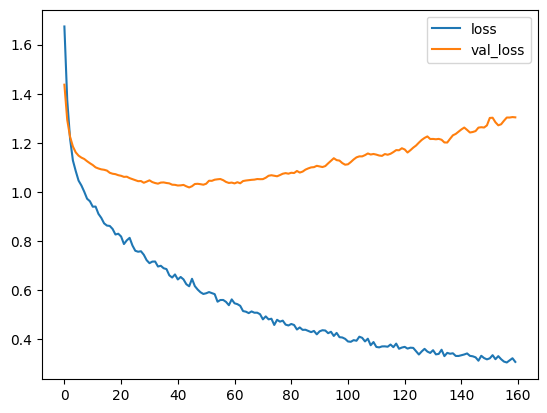

In [17]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Minimum Training Loss: 0.5699
Minimum Validation Loss: 1.0163
Maximum Training Accuracy: 0.8107
Maximum Validation Accuracy: 0.6479


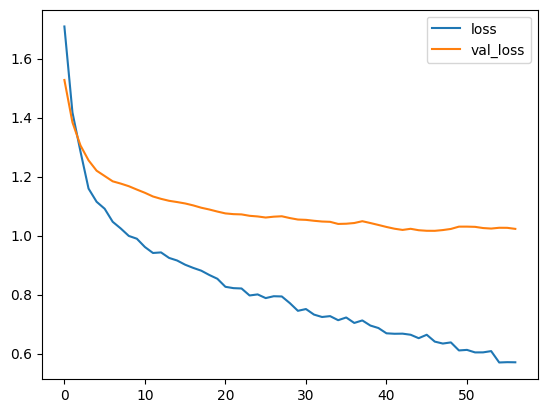

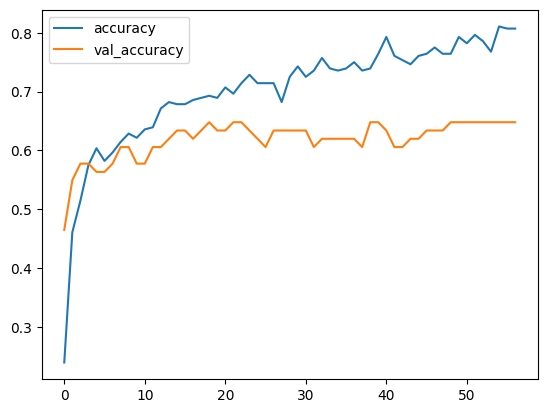

In [26]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Training Loss: {:0.4f}").format(history_df['loss'].min()))
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))
history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()
print(("Maximum Training Accuracy: {:0.4f}").format(history_df['accuracy'].max()))
print(("Maximum Validation Accuracy: {:0.4f}").format(history_df['val_accuracy'].max()))